## Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 


In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
import transformers
import matplotlib.pyplot as plt
%matplotlib inline

import re
import warnings
warnings.filterwarnings("ignore")

# 1. Подготовка

In [2]:
df = pd.read_csv('datasets/toxic_comments.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [3]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


# 2. Обучение

### Bag of Words

Формирование признаков техникой "мешок слов".   

Вначале попробуем просчитать модели с различными параметрами "мешка слов".  
Полученные таким образом признаки с лучшим значением метрики f1_score применим для улучшения этой метрики с помощью изменения гиперпараметров модели логистической регрессии.

In [4]:
scores = []

train, test, target_train, target_test = train_test_split(df['text'], df['toxic'], test_size=0.25)

def model_train(params_for_features, params_for_model):
    
    count_vectorizer = CountVectorizer(stop_words='english', analyzer='word', 
                                       token_pattern=r'[a-zA-Z]{2,}', **params_for_features)
    cv_train = count_vectorizer.fit_transform(train)
    cv_test = count_vectorizer.transform(test)

    model = LogisticRegression(random_state=123, **params_for_model)
    model.fit(cv_train, target_train)

    f1_score_train = f1_score(target_train, model.predict(cv_train))
    f1_score_test = f1_score(target_test, model.predict(cv_test))

    name = 'maxdf{max_df}+mindf{min_df}+C{C}+{solver}'.format(**params_for_features, **params_for_model)
    scores.append([name, f1_score_train, f1_score_test])


In [5]:
%%time
# создание мешка слов со стандартными параметрами max_df и min_df
scores = []
params_for_features = {
    'max_df': 1., 
    'min_df': 1, 
}
model_train(params_for_features, {'C': 1, 'solver':'liblinear'})
model_train(params_for_features, {'C': 1, 'solver':'lbfgs'})
model_train(params_for_features, {'C': 1, 'solver':'sag'})

pd.DataFrame(scores, columns=['params', 'f1_train', 'f1_test'])

CPU times: user 1min 2s, sys: 22 s, total: 1min 23s
Wall time: 42.1 s


,params,f1_train,f1_test
0,maxdf1.0+mindf1+C1+liblinear,0.766176,0.709140
1,maxdf1.0+mindf1+C1+lbfgs,0.884898,0.751976
2,maxdf1.0+mindf1+C1+sag,0.361173,0.353968


Максимальные значения метрики получаются при расчете моделей логистической регрессии с параметром solver='lbfgs'.  
Далее будем использовать этот параметр именно с этим значением при работе с логистической регрессией.

In [6]:
%%time

scores = []
# модели с созданием мешка слов с другими max_df и min_df
for max_df in 0.85, 0.9, 0.95, 1.:
    for min_df in 1, 2, 5, 10:
        params_for_features = {
            'max_df': max_df, 
            'min_df': min_df, 
        }
        model_train(params_for_features, {'C': 1, 'solver':'lbfgs'})

CPU times: user 4min 3s, sys: 1min 30s, total: 5min 34s
Wall time: 2min 40s


In [7]:
df_scores = pd.DataFrame(scores, columns=['params', 'f1_train', 'f1_test'])
df_scores_max = df_scores[df_scores['f1_test'] == df_scores['f1_test'].max()].reset_index()
df_scores_max

,index,params,f1_train,f1_test
0,0,maxdf0.85+mindf1+C1+lbfgs,0.884898,0.751976
1,4,maxdf0.9+mindf1+C1+lbfgs,0.884898,0.751976
2,8,maxdf0.95+mindf1+C1+lbfgs,0.884898,0.751976
3,12,maxdf1.0+mindf1+C1+lbfgs,0.884898,0.751976


Таким образом, обнаружили, что создание мешка слов со стандартными параметрами max_df и min_df показывает максимальное значение метрики f1_score на модели логистической регрессии с solver='lbfgs'.

In [8]:
best_param = {
    'max_df': 1., 
    'min_df': 1, 
}
print('best_param:', best_param)

best_param: {'max_df': 1.0, 'min_df': 1}


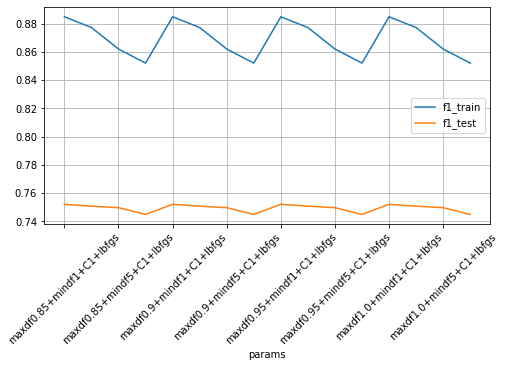

In [9]:
df_scores.plot.line(x='params', grid=True, figsize=(8, 4), rot=45);

In [10]:
%%time
# расчет логистической регрессии с различными значениями гиперпараметра С
scores = []
for c in 0.5, 1, 5, 10:
    model_train(best_param, {'C': c, 'solver':'lbfgs'})

CPU times: user 1min 17s, sys: 32.6 s, total: 1min 49s
Wall time: 46.4 s


In [11]:
df_scores2 = pd.DataFrame(scores, columns=['params', 'f1_train', 'f1_test'])
df_scores2['best'] = df_scores2.loc[1, 'f1_test']
df_scores2.sort_values('f1_test', ascending=False).head()

,params,f1_train,f1_test,best
3,maxdf1.0+mindf1+C10+lbfgs,0.929298,0.766662,0.751976
2,maxdf1.0+mindf1+C5+lbfgs,0.929490,0.765507,0.751976
1,maxdf1.0+mindf1+C1+lbfgs,0.884898,0.751976,0.751976
0,maxdf1.0+mindf1+C0.5+lbfgs,0.854367,0.743197,0.751976


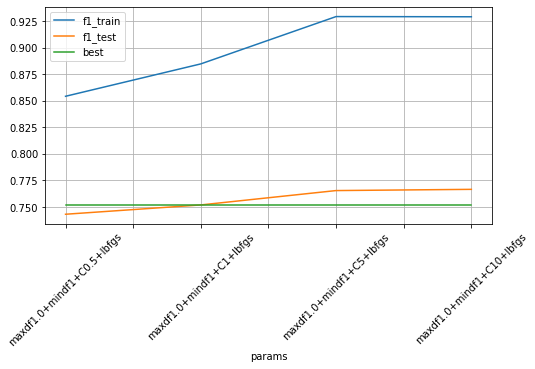

In [12]:
df_scores2.plot.line(x='params', grid=True, figsize=(8, 4), rot=45);

Изменение гиперпараметра С в модели логистической регрессии слабо повлияла на улучшение качества модели.  

**Итак, лучшие показатели метрики f1_score=0.765543 было получено при формировании признаков техникой "мешок слов" с параметрами 'max_df': 1., 'min_df': 1 и гиперпараметром С=5 модели логистической регрессии.**
***

### TF-IDF


In [13]:
def tf_model_train(params_for_features, params_for_model):
    tf = TfidfVectorizer(stop_words='english', analyzer='word', 
                         token_pattern=r'[a-zA-Z]{2,}', **params_for_features)

    tf_train = tf.fit_transform(train)
    tf_test = tf.transform(test)
            
    model = LogisticRegression(random_state=123, solver='lbfgs', **params_for_model)

    model.fit(tf_train, target_train)
    f1_score_train = f1_score(target_train, model.predict(tf_train))
    f1_score_test = f1_score(target_test, model.predict(tf_test))

    name = 'maxdf{max_df}+mindf{min_df}+C{C}'.format(**params_for_features, **params_for_model)
    scores.append([name, f1_score_train, f1_score_test])


In [14]:
%%time

# создание признаков со стандартными параметрами max_df и min_df
scores = []
params_for_features = {
    'max_df': 1., 
    'min_df': 1, 
}
tf_model_train(params_for_features, {'C': 1})

pd.DataFrame(scores, columns=['params', 'f1_train', 'f1_test'])

CPU times: user 17 s, sys: 6.47 s, total: 23.4 s
Wall time: 10.7 s


,params,f1_train,f1_test
0,maxdf1.0+mindf1+C1,0.761749,0.716245


In [15]:
%%time

scores = []
# создание признаков с другими параметрами max_df и min_df

for max_df in 0.85, 0.90, 0.95, 1.:
    for min_df in 1, 2, 5, 10:
        params_for_features = {
            'max_df': max_df, 
            'min_df': min_df, 
        }
        tf_model_train(params_for_features, {'C': 1})

CPU times: user 3min 43s, sys: 1min 17s, total: 5min
Wall time: 2min 31s


In [16]:
df_tf_scores = pd.DataFrame(scores, columns=['params', 'f1_train', 'f1_test'])
df_tf_scores_max = df_tf_scores[df_tf_scores['f1_test'] == df_tf_scores['f1_test'].max()].reset_index()
df_tf_scores_max

,index,params,f1_train,f1_test
0,3,maxdf0.85+mindf10+C1,0.770072,0.723565
1,7,maxdf0.9+mindf10+C1,0.770072,0.723565
2,11,maxdf0.95+mindf10+C1,0.770072,0.723565
3,15,maxdf1.0+mindf10+C1,0.770072,0.723565


In [17]:
substr_tf = lambda y: df_tf_scores_max.loc[0, 'params'].split(y)[1].split('+')[0]
                    
tf_best_param = {
    'max_df': float(substr_tf('maxdf')), 
    'min_df': int(substr_tf('mindf')), 
}
print('tf_best_param:', tf_best_param)

tf_best_param: {'max_df': 0.85, 'min_df': 10}


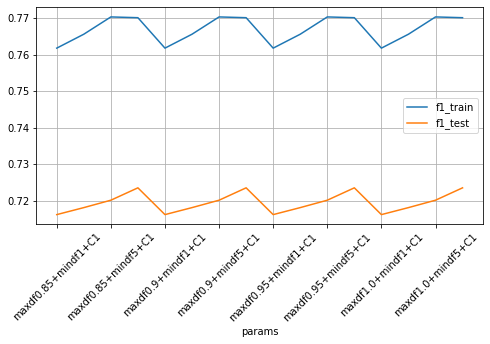

In [18]:
df_tf_scores.plot.line(x='params', grid=True, figsize=(8, 4), rot=45);

### RandomForestClassifier

In [19]:
train, test, target_train, target_test = train_test_split(df['text'], df['toxic'], test_size=0.25)

count_vectorizer = CountVectorizer(stop_words='english', analyzer='word', token_pattern=r'[a-zA-Z]{2,}')

cv_train = count_vectorizer.fit_transform(train)
cv_test = count_vectorizer.transform(test)


In [20]:
%%time
# Расчет модели при стандартных параметрах

model = RandomForestClassifier(random_state=123)
model.fit(cv_train, target_train)

f1_score_train = f1_score(target_train, model.predict(cv_train))
f1_score_test = f1_score(target_test, model.predict(cv_test))
f1_score_train, f1_score_test

CPU times: user 57.9 s, sys: 73.8 ms, total: 58 s
Wall time: 58 s


(0.976292200720449, 0.6898196452526457)

При стандартных параметрах модель Случайного леса показал худшее качество, чем на модели логистической регрессии.  
Я сомневался в том, что это качество значительно улучшится при варьировании гиперпараметров модели.  
И действительно - при больших "танцах с бубнами" удалось выйти на уровень f1=0.73 (пример приведен ниже), что не дотягивает до требуемого уровня. Вероятно, можно подобрать более оптимальные параметры, но это требует больших ресурсов и времени.

In [21]:
%%time

model = RandomForestClassifier(random_state=123, n_estimators=10, max_depth=1000, n_jobs=-1, max_features=None)
model.fit(cv_train, target_train)

f1_score_train = f1_score(target_train, model.predict(cv_train))
f1_score_test = f1_score(target_test, model.predict(cv_test))
f1_score_train, f1_score_test

CPU times: user 33min 11s, sys: 13.4 s, total: 33min 24s
Wall time: 10min 2s


(0.96874476286241, 0.7265069755198736)

### GradientBoostingClassifier

In [22]:
%%time
# Расчет модели при стандартных параметрах

model = GradientBoostingClassifier(random_state=123)

model.fit(cv_train, target_train)

f1_score_train = f1_score(target_train, model.predict(cv_train))
f1_score_test = f1_score(target_test, model.predict(cv_test))
f1_score_train, f1_score_test

CPU times: user 1min, sys: 63.1 ms, total: 1min
Wall time: 1min


(0.5865852279153942, 0.5695614789337919)

In [23]:
%%time

model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, 
                                   max_depth=100, max_features=None, min_samples_leaf=3, 
                                   subsample=1., random_state=123)

model.fit(cv_train, target_train)

f1_score_train = f1_score(target_train, model.predict(cv_train))
f1_score_test = f1_score(target_test, model.predict(cv_test))
f1_score_train, f1_score_test

CPU times: user 1h 3min 30s, sys: 1.37 s, total: 1h 3min 31s
Wall time: 1h 3min 32s


(0.9668739687777637, 0.7494835422118166)

Как видно из результатов расчетов - при стандарных параметрах расчета значение метрики f1_score очень далеко от нужного нам порога в 0,75.  
Но стоило поменять 2 параметра: max_depth=100 и min_samples_leaf=3 - как модель сразу же достигла требуемого порога (0.752286). Но время вычислений выросло во много раз и превысило 1 час.  
При некотором запасе ресурсов вариацией гиперпараметров можно было бы достичь гораздо более высокого значения метрики.
***

### CatBoostClassifier

In [24]:
%%time
# Расчет модели при стандартных параметрах

model = CatBoostClassifier(random_seed=123, thread_count=-1)

model.fit(cv_train, target_train)

f1_score_train = f1_score(target_train, model.predict(cv_train))
f1_score_test = f1_score(target_test, model.predict(cv_test))
'f1_score_train: {}'.format(f1_score_train), 'f1_score_test: {}'.format(f1_score_test)

Learning rate set to 0.079478
0:	learn: 0.6129387	total: 599ms	remaining: 9m 58s
1:	learn: 0.5465071	total: 1.12s	remaining: 9m 18s
2:	learn: 0.4909372	total: 1.63s	remaining: 9m 2s
3:	learn: 0.4472322	total: 2.15s	remaining: 8m 56s
4:	learn: 0.4124967	total: 2.67s	remaining: 8m 50s
5:	learn: 0.3825227	total: 3.18s	remaining: 8m 47s
6:	learn: 0.3585261	total: 3.7s	remaining: 8m 44s
7:	learn: 0.3373812	total: 4.23s	remaining: 8m 44s
8:	learn: 0.3208638	total: 4.75s	remaining: 8m 43s
9:	learn: 0.3067008	total: 5.28s	remaining: 8m 42s
10:	learn: 0.2948166	total: 5.8s	remaining: 8m 41s
11:	learn: 0.2850201	total: 6.32s	remaining: 8m 39s
12:	learn: 0.2757720	total: 6.85s	remaining: 8m 40s
13:	learn: 0.2687648	total: 7.37s	remaining: 8m 39s
14:	learn: 0.2623609	total: 7.91s	remaining: 8m 39s
15:	learn: 0.2565466	total: 8.47s	remaining: 8m 40s
16:	learn: 0.2522086	total: 8.98s	remaining: 8m 39s
17:	learn: 0.2483935	total: 9.52s	remaining: 8m 39s
18:	learn: 0.2449238	total: 10s	remaining: 8m 3

157:	learn: 0.1698872	total: 1m 25s	remaining: 7m 34s
158:	learn: 0.1697075	total: 1m 25s	remaining: 7m 34s
159:	learn: 0.1695153	total: 1m 26s	remaining: 7m 33s
160:	learn: 0.1693315	total: 1m 26s	remaining: 7m 33s
161:	learn: 0.1691390	total: 1m 27s	remaining: 7m 32s
162:	learn: 0.1689655	total: 1m 28s	remaining: 7m 32s
163:	learn: 0.1687692	total: 1m 28s	remaining: 7m 31s
164:	learn: 0.1685681	total: 1m 29s	remaining: 7m 31s
165:	learn: 0.1684272	total: 1m 29s	remaining: 7m 30s
166:	learn: 0.1682843	total: 1m 30s	remaining: 7m 30s
167:	learn: 0.1681311	total: 1m 30s	remaining: 7m 29s
168:	learn: 0.1679496	total: 1m 31s	remaining: 7m 28s
169:	learn: 0.1677705	total: 1m 31s	remaining: 7m 28s
170:	learn: 0.1675078	total: 1m 32s	remaining: 7m 28s
171:	learn: 0.1673133	total: 1m 32s	remaining: 7m 27s
172:	learn: 0.1671289	total: 1m 33s	remaining: 7m 27s
173:	learn: 0.1669081	total: 1m 34s	remaining: 7m 26s
174:	learn: 0.1667601	total: 1m 34s	remaining: 7m 25s
175:	learn: 0.1665683	total:

310:	learn: 0.1496849	total: 2m 49s	remaining: 6m 14s
311:	learn: 0.1496219	total: 2m 49s	remaining: 6m 14s
312:	learn: 0.1495208	total: 2m 50s	remaining: 6m 13s
313:	learn: 0.1494269	total: 2m 50s	remaining: 6m 13s
314:	learn: 0.1493562	total: 2m 51s	remaining: 6m 12s
315:	learn: 0.1492742	total: 2m 51s	remaining: 6m 11s
316:	learn: 0.1491721	total: 2m 52s	remaining: 6m 11s
317:	learn: 0.1490663	total: 2m 52s	remaining: 6m 10s
318:	learn: 0.1489982	total: 2m 53s	remaining: 6m 10s
319:	learn: 0.1489603	total: 2m 53s	remaining: 6m 9s
320:	learn: 0.1488579	total: 2m 54s	remaining: 6m 9s
321:	learn: 0.1487467	total: 2m 55s	remaining: 6m 8s
322:	learn: 0.1486500	total: 2m 55s	remaining: 6m 8s
323:	learn: 0.1485941	total: 2m 56s	remaining: 6m 7s
324:	learn: 0.1485609	total: 2m 56s	remaining: 6m 7s
325:	learn: 0.1484509	total: 2m 57s	remaining: 6m 6s
326:	learn: 0.1484123	total: 2m 57s	remaining: 6m 5s
327:	learn: 0.1483397	total: 2m 58s	remaining: 6m 5s
328:	learn: 0.1482189	total: 2m 58s	r

464:	learn: 0.1393028	total: 4m 14s	remaining: 4m 52s
465:	learn: 0.1392427	total: 4m 14s	remaining: 4m 51s
466:	learn: 0.1391865	total: 4m 15s	remaining: 4m 51s
467:	learn: 0.1391420	total: 4m 15s	remaining: 4m 50s
468:	learn: 0.1390976	total: 4m 16s	remaining: 4m 50s
469:	learn: 0.1390587	total: 4m 16s	remaining: 4m 49s
470:	learn: 0.1389910	total: 4m 17s	remaining: 4m 49s
471:	learn: 0.1388988	total: 4m 18s	remaining: 4m 48s
472:	learn: 0.1388338	total: 4m 18s	remaining: 4m 48s
473:	learn: 0.1388125	total: 4m 19s	remaining: 4m 47s
474:	learn: 0.1387385	total: 4m 19s	remaining: 4m 47s
475:	learn: 0.1387033	total: 4m 20s	remaining: 4m 46s
476:	learn: 0.1386368	total: 4m 20s	remaining: 4m 45s
477:	learn: 0.1386132	total: 4m 21s	remaining: 4m 45s
478:	learn: 0.1385921	total: 4m 21s	remaining: 4m 44s
479:	learn: 0.1384983	total: 4m 22s	remaining: 4m 44s
480:	learn: 0.1384777	total: 4m 22s	remaining: 4m 43s
481:	learn: 0.1384348	total: 4m 23s	remaining: 4m 43s
482:	learn: 0.1384141	total:

617:	learn: 0.1323419	total: 5m 38s	remaining: 3m 29s
618:	learn: 0.1322987	total: 5m 39s	remaining: 3m 28s
619:	learn: 0.1322839	total: 5m 39s	remaining: 3m 28s
620:	learn: 0.1322420	total: 5m 40s	remaining: 3m 27s
621:	learn: 0.1321873	total: 5m 40s	remaining: 3m 27s
622:	learn: 0.1321652	total: 5m 41s	remaining: 3m 26s
623:	learn: 0.1320929	total: 5m 41s	remaining: 3m 26s
624:	learn: 0.1320200	total: 5m 42s	remaining: 3m 25s
625:	learn: 0.1319684	total: 5m 43s	remaining: 3m 24s
626:	learn: 0.1319241	total: 5m 43s	remaining: 3m 24s
627:	learn: 0.1318542	total: 5m 44s	remaining: 3m 23s
628:	learn: 0.1317881	total: 5m 44s	remaining: 3m 23s
629:	learn: 0.1317470	total: 5m 45s	remaining: 3m 22s
630:	learn: 0.1316946	total: 5m 45s	remaining: 3m 22s
631:	learn: 0.1316318	total: 5m 46s	remaining: 3m 21s
632:	learn: 0.1315766	total: 5m 46s	remaining: 3m 21s
633:	learn: 0.1315279	total: 5m 47s	remaining: 3m 20s
634:	learn: 0.1314647	total: 5m 48s	remaining: 3m 20s
635:	learn: 0.1314500	total:

770:	learn: 0.1263545	total: 7m 3s	remaining: 2m 5s
771:	learn: 0.1263429	total: 7m 4s	remaining: 2m 5s
772:	learn: 0.1262909	total: 7m 4s	remaining: 2m 4s
773:	learn: 0.1262760	total: 7m 5s	remaining: 2m 4s
774:	learn: 0.1262387	total: 7m 6s	remaining: 2m 3s
775:	learn: 0.1262265	total: 7m 6s	remaining: 2m 3s
776:	learn: 0.1262080	total: 7m 7s	remaining: 2m 2s
777:	learn: 0.1261429	total: 7m 7s	remaining: 2m 2s
778:	learn: 0.1261310	total: 7m 8s	remaining: 2m 1s
779:	learn: 0.1261193	total: 7m 9s	remaining: 2m 1s
780:	learn: 0.1261077	total: 7m 9s	remaining: 2m
781:	learn: 0.1260663	total: 7m 10s	remaining: 1m 59s
782:	learn: 0.1260288	total: 7m 10s	remaining: 1m 59s
783:	learn: 0.1260170	total: 7m 11s	remaining: 1m 58s
784:	learn: 0.1259737	total: 7m 11s	remaining: 1m 58s
785:	learn: 0.1259590	total: 7m 12s	remaining: 1m 57s
786:	learn: 0.1258900	total: 7m 13s	remaining: 1m 57s
787:	learn: 0.1258373	total: 7m 13s	remaining: 1m 56s
788:	learn: 0.1258258	total: 7m 14s	remaining: 1m 56s

924:	learn: 0.1228243	total: 8m 31s	remaining: 41.4s
925:	learn: 0.1228142	total: 8m 31s	remaining: 40.9s
926:	learn: 0.1228042	total: 8m 32s	remaining: 40.3s
927:	learn: 0.1227471	total: 8m 32s	remaining: 39.8s
928:	learn: 0.1227028	total: 8m 33s	remaining: 39.2s
929:	learn: 0.1226929	total: 8m 33s	remaining: 38.7s
930:	learn: 0.1226832	total: 8m 34s	remaining: 38.1s
931:	learn: 0.1226733	total: 8m 34s	remaining: 37.6s
932:	learn: 0.1226496	total: 8m 35s	remaining: 37s
933:	learn: 0.1226395	total: 8m 35s	remaining: 36.5s
934:	learn: 0.1226299	total: 8m 36s	remaining: 35.9s
935:	learn: 0.1226199	total: 8m 37s	remaining: 35.4s
936:	learn: 0.1226100	total: 8m 37s	remaining: 34.8s
937:	learn: 0.1225584	total: 8m 38s	remaining: 34.3s
938:	learn: 0.1225373	total: 8m 38s	remaining: 33.7s
939:	learn: 0.1225223	total: 8m 39s	remaining: 33.2s
940:	learn: 0.1225126	total: 8m 39s	remaining: 32.6s
941:	learn: 0.1225027	total: 8m 40s	remaining: 32s
942:	learn: 0.1224918	total: 8m 41s	remaining: 31.

('f1_score_train: 0.7556689898890743', 'f1_score_test: 0.7144136078782453')

In [25]:
%%time
# Расчет модели при стандартных параметрах

model = CatBoostClassifier(random_seed=123, thread_count=-1, iterations=500, verbose=False, learning_rate=1)

model.fit(cv_train, target_train)

f1_score_train = f1_score(target_train, model.predict(cv_train))
f1_score_test = f1_score(target_test, model.predict(cv_test))
'f1_score_train: {}'.format(f1_score_train), 'f1_score_test: {}'.format(f1_score_test)

CPU times: user 11min 49s, sys: 8.8 s, total: 11min 58s
Wall time: 4min 42s


('f1_score_train: 0.8723423104181431', 'f1_score_test: 0.748753462603878')

# 3. Выводы

Первое, что хотелось бы отметить - признаки, полученные техникой "мешок слов" (в отличие техники TF_IDF), уже на стандартных параметрах модели логистической регрессии дают значение метрики f1 выше требуемого порога в 0,75.

"Мешок слов" был проверен и на других моделях классификации - RandomForestClassifier, GradientBoostingClassifier и CatBoostClassifier - и почти на всех этих видах моделей были подобраны параметры, при котором значение f1 превысило необходимый порог.  
Но при этом некоторые модели затрачивали очень большое время на расчеты. 

---